In [1]:
cd ../

/home/noahb/workspace/fv3net


In [2]:
from src.data.regrid import *
from scipy.ndimage import map_coordinates

In [3]:

import xarray as xr
import matplotlib.pyplot as plt

data_2d = xr.open_zarr("data/interim/2019-07-17-GFDL_FV3_DYAMOND_0.25deg_15minute_2d.zarr/")
data_3d = xr.open_zarr("data/interim/2019-07-17-GFDL_FV3_DYAMOND_0.25deg_15minute_3d.zarr/")

In [4]:
data_3d = data_3d.isel(time=slice(0, 1))

In [5]:
# load sam NG-Aqua grid

In [6]:
import numpy as np

In [7]:
z = np.loadtxt('assets/sam_ngaqua_grd')
z = xr.DataArray(z, name='z', dims=['z'], coords={'z': z})

In [8]:
h = height_on_model_levels(data_3d)
height_on_heights = interpolate_1d(z, h, h)

In [9]:
h.load()

<xarray.DataArray (time: 1, grid_yt: 768, grid_xt: 1536, pfull: 79)>
array([[[[3.202018e+04, ..., 2.821464e+03],
         ...,
         [3.202020e+04, ..., 2.821288e+03]],

        ...,

        [[3.790659e+04, ..., 1.392252e+01],
         ...,
         [3.790658e+04, ..., 1.390909e+01]]]], dtype=float32)
Coordinates:
  * grid_xt  (grid_xt) float32 0.1171875 0.3515625 ... 359.64844 359.8828
  * grid_yt  (grid_yt) float32 -89.88281 -89.64844 ... 89.64844 89.88281
  * pfull    (pfull) float32 4.5137978 8.300872 12.451992 ... 994.3374 998.2764
  * time     (time) object 2016-08-01 03:00:00

In [10]:
data_3d

<xarray.Dataset>
Dimensions:       (bnds: 2, grid_xt: 1536, grid_yt: 768, pfull: 79, phalf: 80, plev: 31, time: 1)
Coordinates:
  * grid_xt       (grid_xt) float32 0.1171875 0.3515625 ... 359.64844 359.8828
  * grid_yt       (grid_yt) float32 -89.88281 -89.64844 ... 89.64844 89.88281
  * pfull         (pfull) float32 4.5137978 8.300872 ... 994.3374 998.2764
  * phalf         (phalf) float32 3.0 6.4671593 10.452223 ... 996.5372 1000.0
  * plev          (plev) float32 1.0 2.0 3.0 5.0 ... 925.0 950.0 975.0 1000.0
  * time          (time) object 2016-08-01 03:00:00
Dimensions without coordinates: bnds
Data variables:
    grid_xt_bnds  (grid_xt, bnds) float32 dask.array<shape=(1536, 2), chunksize=(1536, 2)>
    grid_yt_bnds  (grid_yt, bnds) float32 dask.array<shape=(768, 2), chunksize=(768, 2)>
    h_plev        (time, plev, grid_yt, grid_xt) float32 dask.array<shape=(1, 31, 768, 1536), chunksize=(1, 31, 768, 1536)>
    pres          (time, pfull, grid_yt, grid_xt) float32 dask.array<shape=

In [11]:
dim_order = ['time', 'pfull', 'grid_yt', 'grid_xt']
dim_order_horizontal = ['grid_yt', 'grid_xt']
radius_earth = 6378e3
dt = 120

# convert lat/lon to meters
x = np.cos(np.deg2rad(data_3d.grid_yt)) * np.deg2rad(data_3d.grid_xt) * radius_earth 
y = np.deg2rad(data_3d.grid_yt) * radius_earth
coords = xr.broadcast(x, y)
args_3d = [height_on_model_levels(data_3d), data_3d.u, data_3d.v, data_3d.w]

# cast args to numpy arrays
coords = [np.asarray(coord.transpose(*dim_order_horizontal)) for coord in coords]
args_3d = [np.asarray(arg.transpose(*dim_order)) for arg in args_3d]
args = coords + args_3d

# compute total deritive
loc = [slice(None), slice(50, 51), slice(None), slice(None)]
origin = lagrangian_origin_coordinates(*args, h=dt)
arg = np.asarray(data_3d.qv.transpose(*dim_order))
test_origin = origin[[slice(None)] + loc]
ans = map_coordinates(arg, test_origin, mode='mirror')
darg = (ans - arg[loc])/dt

/home/noahb/.conda/envs/uwnet/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/noahb/.conda/envs/uwnet/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [12]:
zone = [0, 0, slice(200, 600), slice(0, 600)]
w_ind = data_3d.w.values[loc]

/home/noahb/.conda/envs/uwnet/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


/home/noahb/.conda/envs/uwnet/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


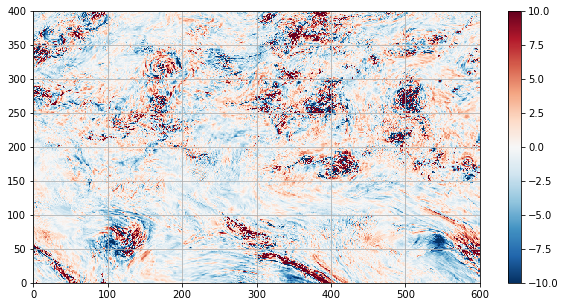

In [13]:
plt.figure(figsize=(10, 5))
plt.pcolormesh(w_ind[zone].squeeze()*100, vmin=-10, vmax=10, cmap='RdBu_r')
plt.colorbar()
plt.grid()

/home/noahb/.conda/envs/uwnet/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


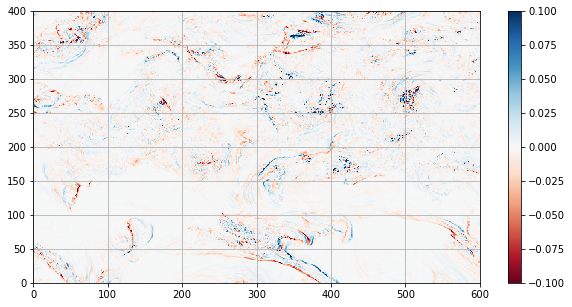

In [14]:
plt.figure(figsize=(10, 5))
plt.pcolormesh(darg[zone].squeeze()*86400, vmin=-.1, vmax=.1, cmap='RdBu')
plt.colorbar()
plt.grid()